In [1]:
# dependencies
import os
import sys
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpl
import seaborn as sns

sns.set()
sns.set_style("dark")
# sns.set_style("whitegrid")
sns.set_context("paper", font_scale=4, rc={"lines.linewidth": 4})
mpl.rcParams['lines.linewidth'] = 3

In [2]:
import pyvista as pv
import geopandas as gpd
from shapely.geometry import Point
from descartes import PolygonPatch

In [3]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon

In [4]:
import random
import datetime

# Get district data

In [5]:
sys.path.insert(0, '../county_data')
from read_county_data import *

In [6]:
sys.path.insert(1, '../district_data')
from read_district_data import *

In [7]:
# get county data
county_nms, county_dist, county_dist_names, county_polys = read_county_map('../county_data/data/')
N_counties = len(county_nms)

In [8]:
# get district data
new_dist_nm, new_dist_county_nbr, new_dist_county_nm, new_dist_geom = read_dist_map('../district_data/data/', county_nms, county_dist, 
                                                  county_dist_names, county_polys, 0)
N_districts = len(new_dist_nm)

In [9]:
for i in range(len(county_nms)):
    print('{0:<16} {1:<10}'.format(county_nms[i], i))

Anderson         0         
Andrews          1         
Angelina         2         
Aransas          3         
Archer           4         
Armstrong        5         
Atascosa         6         
Austin           7         
Bailey           8         
Bandera          9         
Bastrop          10        
Baylor           11        
Bee              12        
Bell             13        
Bexar            14        
Blanco           15        
Borden           16        
Bosque           17        
Bowie            18        
Brazoria         19        
Brazos           20        
Brewster         21        
Briscoe          22        
Brooks           23        
Brown            24        
Burleson         25        
Burnet           26        
Caldwell         27        
Calhoun          28        
Callahan         29        
Cameron          30        
Camp             31        
Carson           32        
Cass             33        
Castro           34        
Chambers         35 

In [10]:
def find_county_id(nm):
    for i in range(N_counties):
        if nm == county_nms[i]:
            return i
            

In [11]:
def diff_day(d1, d2):
    d1 = datetime.datetime.strptime("{}-{}-{}".format(d1[2],d1[1],d1[0]), "%Y-%m-%d")
    d2 = datetime.datetime.strptime("{}-{}-{}".format(d2[2],d2[1],d2[0]), "%Y-%m-%d")
    return abs((d2-d1)).days

In [12]:
print(diff_day([4, 3, 2020], [7, 3, 2020]))

3


# Read COVID-19 data

We need to first process data taking care of following issues:

- In all the data, the deceased and active data lag by one day compared to infected data

For total infected cases: 
- Data at following dates are missing: 7,8,14 March. Add values for these dates by copying the values of previous dates

- Cases only start from 6 March 2020. Start data from this date

For active infected cases:
- Data begins on April 7

For 11 August data:
- Deceased cases data begins on 7 March


For 11 August data:
- we store processed data 7 March 2020 onwards

In [66]:
data_path = 'Data_11August2020/'
infected_total_cases_data = pd.read_csv(data_path + 'infected_total.csv')
infected_total_cases_data = infected_total_cases_data.T
infected_total_cases_data

,0,1,2,3,4,5,6,7,8,9,...,244,245,246,247,248,249,250,251,252,253
0,1,2,3,4,5,6,7,8,9,10,...,245,246,247,248,249,250,251,252,253,254
1,Anderson,Andrews,Angelina,Aransas,Archer,Armstrong,Atascosa,Austin,Bailey,Bandera,...,Willacy,Williamson,Wilson,Winkler,Wise,Wood,Yoakum,Young,Zapata,Zavala
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,2353,277,1769,165,21,7,425,223,168,89,...,669,5949,434,73,375,316,96,151,167,202
155,2379,279,1796,169,21,8,434,230,170,89,...,682,6058,434,80,390,316,100,160,170,205
156,2402,297,1796,172,21,8,437,230,171,91,...,691,6245,439,84,409,316,102,169,172,210
157,2402,297,1796,173,21,8,437,242,171,91,...,693,6245,439,84,409,316,102,169,172,210


In [67]:
deceased_cases_data = pd.read_csv(data_path + 'deceased.csv')
deceased_cases_data = deceased_cases_data.T
deceased_cases_data

,0,1,2,3,4,5,6,7,8,9,...,244,245,246,247,248,249,250,251,252,253
0,1,2,3,4,5,6,7,8,9,10,...,245,246,247,248,249,250,251,252,253,254
1,Anderson,Andrews,Angelina,Aransas,Archer,Armstrong,Atascosa,Austin,Bailey,Bandera,...,Willacy,Williamson,Wilson,Winkler,Wise,Wood,Yoakum,Young,Zapata,Zavala
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,14,7,45,15,0,0,18,4,4,3,...,30,93,19,1,7,7,3,5,2,5
154,14,7,45,15,0,0,18,4,4,3,...,30,93,19,1,7,7,3,5,2,5
155,14,7,45,15,0,0,18,4,4,3,...,30,93,19,1,7,7,3,5,2,5
156,14,7,45,15,0,0,18,4,4,3,...,30,93,19,1,7,7,3,5,2,5


In [68]:
infected_active_cases_data = pd.read_csv(data_path + 'infected_active.csv')
infected_active_cases_data = infected_active_cases_data.T
infected_active_cases_data

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,1,2,3,4,5,6,7,8,9,10,...,247,248,249,250,251,252,253,254,NaN,NaN
1,Anderson,Andrews,Angelina,Aransas,Archer,Armstrong,Atascosa,Austin,Bailey,Bandera,...,Wilson,Winkler,Wise,Wood,Yoakum,Young,Zapata,Zavala,NaN,NaN
2,1,10,14,1,0,0,4,6,0,0,...,7,0,3,4,0,3,1,0,NaN,NaN
3,1,10,14,2,0,0,3,6,0,0,...,7,0,3,4,0,3,1,0,NaN,NaN
4,2,10,14,2,0,0,3,6,0,1,...,8,0,3,4,0,3,3,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,2146,80,857,83,0,4,76,78,42,37,...,89,17,11,120,26,9,71,98,NaN,NaN
123,2144,76,869,80,0,4,73,82,42,36,...,87,16,10,122,31,3,73,90,NaN,NaN
124,2170,76,893,69,0,4,79,86,43,28,...,82,23,9,80,28,6,47,85,NaN,NaN
125,2191,93,891,69,0,4,78,82,42,26,...,75,24,28,79,30,15,38,85,NaN,NaN


In [69]:
# list(infected_cases_data.columns)
# list(infected_cases_data.index)

In [70]:
for i in range(N_counties):
    
    if infected_total_cases_data[i][1] != infected_active_cases_data[i][1]:
        print('inf cname: {}, act cname: {}'.format(infected_total_cases_data[i][1], 
                                                    infected_active_cases_data[i][1]))


In [71]:
COUNTY_NAME_ROW_INDEX = 1
CASES_START_ROW_INDEX = 2

##
INFECTED_TOTAL_DATA_DAY_BEGIN = [4, 3, 2020]
INFECTED_TOTAL_DAY_BEGIN = [7, 3, 2020]
INFECTED_TOTAL_IGNORE_DATA_DAYS = diff_day(INFECTED_TOTAL_DATA_DAY_BEGIN, INFECTED_TOTAL_DAY_BEGIN)
INFECTED_TOTAL_MISSING_DAYS = 3

INFECTED_TOTAL_IGNORE_LAST_DAYS = 1

print("INFECTED_TOTAL_IGNORE_DATA_DAYS: {}".format(INFECTED_TOTAL_IGNORE_DATA_DAYS))

##
INFECTED_ACTIVE_DATA_DAY_BEGIN = [7, 4, 2020]

##
DECEASED_DATA_DAY_BEGIN = [7, 3, 2020]
DECEASED_DAY_BEGIN = [7, 3, 2020]
DECEASED_IGNORE_DATA_DAYS = diff_day(DECEASED_DATA_DAY_BEGIN, DECEASED_DAY_BEGIN)
DECEASED_MISSING_DAYS = 0
print("DECEASED_IGNORE_DATA_DAYS: {}".format(DECEASED_IGNORE_DATA_DAYS))

INFECTED_TOTAL_IGNORE_DATA_DAYS: 3
DECEASED_IGNORE_DATA_DAYS: 0


In [72]:
INFECTED_TOTAL_DATA_TOTAL_DAYS = len(infected_total_cases_data[0]) - CASES_START_ROW_INDEX \
                                - INFECTED_TOTAL_IGNORE_DATA_DAYS + INFECTED_TOTAL_MISSING_DAYS \
                                - INFECTED_TOTAL_IGNORE_LAST_DAYS
print(INFECTED_TOTAL_DATA_TOTAL_DAYS)

156


In [73]:
INFECTED_ACTIVE_DATA_TOTAL_DAYS = len(infected_active_cases_data[0]) - CASES_START_ROW_INDEX
print(INFECTED_ACTIVE_DATA_TOTAL_DAYS)

125


In [74]:
DECEASED_DATA_TOTAL_DAYS = len(deceased_cases_data[0]) - CASES_START_ROW_INDEX \
                            - DECEASED_IGNORE_DATA_DAYS + DECEASED_MISSING_DAYS
print(DECEASED_DATA_TOTAL_DAYS)

156


In [75]:
DATA_TOTAL_DAYS = INFECTED_TOTAL_DATA_TOTAL_DAYS
DATA_DAY_BEGIN = INFECTED_TOTAL_DAY_BEGIN
# print(DATA_TOTAL_DAYS)

In [76]:
# list(covid_data.columns)
covid_data_county_nms = [infected_total_cases_data[i][COUNTY_NAME_ROW_INDEX] for i in range(N_counties)]
covid_data_county_nbr = [0 for i in range(N_counties)]
for i in range(N_counties):
    nm = infected_total_cases_data[i][COUNTY_NAME_ROW_INDEX]
    covid_data_county_nbr[i] = find_county_id(nm)
            
for i in range(N_counties):
    print('col id: {0: <6} col name: {1: <16} county nbr: {2: <6} county nm: {3: <16} match: {4}'.format(i, 
            covid_data_county_nms[i], covid_data_county_nbr[i], 
            county_nms[covid_data_county_nbr[i]], county_nms[i] == covid_data_county_nms[i]))
    
    

col id: 0      col name: Anderson         county nbr: 0      county nm: Anderson         match: True
col id: 1      col name: Andrews          county nbr: 1      county nm: Andrews          match: True
col id: 2      col name: Angelina         county nbr: 2      county nm: Angelina         match: True
col id: 3      col name: Aransas          county nbr: 3      county nm: Aransas          match: True
col id: 4      col name: Archer           county nbr: 4      county nm: Archer           match: True
col id: 5      col name: Armstrong        county nbr: 5      county nm: Armstrong        match: True
col id: 6      col name: Atascosa         county nbr: 6      county nm: Atascosa         match: True
col id: 7      col name: Austin           county nbr: 7      county nm: Austin           match: True
col id: 8      col name: Bailey           county nbr: 8      county nm: Bailey           match: True
col id: 9      col name: Bandera          county nbr: 9      county nm: Bandera          ma

# map COVID-19 data so that county numbering is consistent with the map

In [77]:
# Get all cases
infected_total_cases = []
total_data_days = len(infected_total_cases_data[0]) - CASES_START_ROW_INDEX
for i in range(total_data_days):
    d = []
    for j in range(N_counties):
        d.append(infected_total_cases_data[j][i+CASES_START_ROW_INDEX])
    infected_total_cases.append(d)
    
infected_total_cases = np.array(infected_total_cases)
# np.savetxt(data_path + 'infected_total_processed_try.txt', infected_total_cases)

In [78]:
# insert missing data on 7,8,14 March
missing_days = [[7,3,2020], [8,3,2020], [14,3,2020]]
for i in range(3):
    insert_index = diff_day(INFECTED_TOTAL_DATA_DAY_BEGIN, missing_days[i])
    print("insert_index: {}".format(insert_index))
    
    if insert_index != 0 and insert_index < len(infected_total_cases):
        infected_total_cases = np.insert(infected_total_cases, insert_index, infected_total_cases[insert_index-1, :], 0)
        print('New size: {}'.format(infected_total_cases.shape))
        print('Copied data: {}'.format(infected_total_cases[insert_index-1, :]))
        print('Added data: {}'.format(infected_total_cases[insert_index, :]))

insert_index: 3
New size: (158, 254)
Copied data: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Added data: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [79]:
# we now remove first few days from the data
infected_total_cases = infected_total_cases[INFECTED_TOTAL_IGNORE_DATA_DAYS:, :]

# also ignore last day data for infected cases, because for this day, there is no deceased and active data
infected_total_cases = infected_total_cases[:-1, :]

In [80]:
# Get all cases
deceased_cases = []
total_data_days = len(deceased_cases_data[0]) - CASES_START_ROW_INDEX
for i in range(total_data_days):
    d = []
    for j in range(N_counties):
        d.append(deceased_cases_data[j][i+CASES_START_ROW_INDEX])
    deceased_cases.append(d)
    
deceased_cases = np.array(deceased_cases)
# np.savetxt(data_path + 'deceased_processed_try.txt', deceased_cases)

In [81]:
# we now remove first 2 days from the data
deceased_cases = deceased_cases[DECEASED_IGNORE_DATA_DAYS:, :]

In [82]:
print('Expected size: {0: <16} Original size infected: {1: <16} Original size deceased: \
      {2}'.format(DATA_TOTAL_DAYS, \
      len(infected_total_cases), len(deceased_cases)))

Expected size: 156              Original size infected: 156              Original size deceased:       156


In [83]:
# Get infected active cases
# first read the data given
temp_cases = []
total_data_days = len(infected_active_cases_data[0]) - CASES_START_ROW_INDEX
for i in range(total_data_days):
    d = []
    for j in range(N_counties):
        d.append(infected_active_cases_data[j][i+CASES_START_ROW_INDEX])
    temp_cases.append(d)
    
print(len(temp_cases))

125


In [90]:
# now create a array of same size as infected_total and deceased cases and for entries before
# April 7, enter infected total cases and after April 7 use the active cases data
infected_active_cases = []
for i in range(DATA_TOTAL_DAYS):
    d = []
    
    if i < DATA_TOTAL_DAYS - INFECTED_ACTIVE_DATA_TOTAL_DAYS:
        #d = infected_total_cases[i] - deceased_cases[i]
        d = [0. for j in range(N_counties)]
    else:
        d = temp_cases[i - INFECTED_ACTIVE_DATA_TOTAL_DAYS]
    infected_active_cases.append(d)
    
infected_active_cases = np.array(infected_active_cases)
# np.savetxt(data_path + 'infected_active_processed_try.txt', infected_active_cases)

In [91]:
print('Expected size: {0:<10} infected total: {1: <2} \
        infected active: {2: <2} \
        deceased: {3}'.format(DATA_TOTAL_DAYS, \
          len(infected_total_cases), len(infected_active_cases), len(deceased_cases)))

Expected size: 156        infected total: 156         infected active: 156         deceased: 156


In [92]:
# np.savetxt(data_path + 'infected_processed_try2.txt', infected_cases)
# np.savetxt(data_path + 'deceased_processed_try2.txt', deceased_cases)

# Check processed data

In [93]:
print(diff_day(INFECTED_TOTAL_DATA_DAY_BEGIN, INFECTED_ACTIVE_DATA_DAY_BEGIN))

for i in range(DATA_TOTAL_DAYS):
    
    if (infected_total_cases[i] < infected_active_cases[i]).all():
        print('active cases is higher than total cases')
        
    for j in range(N_counties):
        if infected_total_cases[i][j] < infected_active_cases[i][j]:
            print('i: {}, inf: {}, act:{}'.format(i, infected_total_cases[i][j], infected_active_cases[i][j]))

34
i: 31, inf: 1, act:28.0
i: 31, inf: 14, act:81.0
i: 31, inf: 0, act:1.0
i: 31, inf: 4, act:10.0
i: 31, inf: 0, act:2.0
i: 31, inf: 0, act:3.0
i: 31, inf: 15, act:69.0
i: 31, inf: 0, act:1.0
i: 31, inf: 68, act:84.0
i: 31, inf: 456, act:824.0
i: 31, inf: 0, act:3.0
i: 31, inf: 17, act:19.0
i: 31, inf: 167, act:280.0
i: 31, inf: 94, act:106.0
i: 31, inf: 0, act:1.0
i: 31, inf: 0, act:1.0
i: 31, inf: 6, act:15.0
i: 31, inf: 5, act:12.0
i: 31, inf: 5, act:17.0
i: 31, inf: 5, act:19.0
i: 31, inf: 12, act:14.0
i: 31, inf: 1, act:4.0
i: 31, inf: 101, act:207.0
i: 31, inf: 0, act:2.0
i: 31, inf: 4, act:7.0
i: 31, inf: 6, act:7.0
i: 31, inf: 0, act:1.0
i: 31, inf: 0, act:2.0
i: 31, inf: 0, act:1.0
i: 31, inf: 3, act:5.0
i: 31, inf: 0, act:3.0
i: 31, inf: 11, act:184.0
i: 31, inf: 0, act:3.0
i: 31, inf: 1, act:8.0
i: 31, inf: 1155, act:2623.0
i: 31, inf: 5, act:15.0
i: 31, inf: 7, act:28.0
i: 31, inf: 337, act:421.0
i: 31, inf: 0, act:2.0
i: 31, inf: 35, act:83.0
i: 31, inf: 125, act:517.0
i:

i: 46, inf: 8, act:38.0
i: 46, inf: 6, act:23.0
i: 46, inf: 1, act:3.0
i: 46, inf: 8, act:25.0
i: 46, inf: 0, act:3.0
i: 46, inf: 3, act:7.0
i: 46, inf: 86, act:196.0
i: 46, inf: 0, act:1.0
i: 46, inf: 2, act:5.0
i: 46, inf: 3, act:11.0
i: 46, inf: 2602, act:3592.0
i: 46, inf: 14, act:105.0
i: 46, inf: 587, act:970.0
i: 46, inf: 1, act:4.0
i: 46, inf: 12, act:13.0
i: 46, inf: 15, act:18.0
i: 46, inf: 0, act:1.0
i: 46, inf: 808, act:1114.0
i: 46, inf: 1, act:8.0
i: 46, inf: 3, act:7.0
i: 46, inf: 1, act:8.0
i: 46, inf: 2, act:3.0
i: 46, inf: 0, act:3.0
i: 46, inf: 1, act:2.0
i: 46, inf: 3, act:58.0
i: 46, inf: 22, act:31.0
i: 46, inf: 19, act:181.0
i: 46, inf: 53, act:77.0
i: 46, inf: 10, act:85.0
i: 46, inf: 0, act:1.0
i: 46, inf: 1, act:8.0
i: 46, inf: 0, act:1.0
i: 46, inf: 5143, act:6011.0
i: 46, inf: 1, act:4.0
i: 46, inf: 0, act:2.0
i: 46, inf: 19, act:23.0
i: 46, inf: 4, act:9.0
i: 46, inf: 1, act:32.0
i: 46, inf: 8, act:11.0
i: 46, inf: 10, act:11.0
i: 46, inf: 0, act:2.0
i: 46,

i: 67, inf: 1, act:3.0
i: 67, inf: 217, act:251.0
i: 67, inf: 2, act:10.0
i: 67, inf: 0, act:5.0
i: 67, inf: 14, act:20.0
i: 67, inf: 6, act:10.0
i: 67, inf: 4, act:5.0
i: 67, inf: 3, act:14.0
i: 67, inf: 4, act:8.0
i: 67, inf: 54, act:249.0
i: 67, inf: 0, act:3.0
i: 67, inf: 8416, act:9223.0
i: 67, inf: 0, act:2.0
i: 67, inf: 214, act:402.0
i: 67, inf: 403, act:441.0
i: 67, inf: 8, act:19.0
i: 67, inf: 21, act:110.0
i: 67, inf: 6, act:10.0
i: 67, inf: 0, act:11.0
i: 67, inf: 58, act:115.0
i: 67, inf: 0, act:1.0
i: 67, inf: 399, act:725.0
i: 67, inf: 7, act:8.0
i: 67, inf: 101, act:291.0
i: 67, inf: 7, act:11.0
i: 67, inf: 6, act:19.0
i: 67, inf: 15, act:21.0
i: 67, inf: 2, act:5.0
i: 67, inf: 5, act:12.0
i: 67, inf: 41, act:58.0
i: 67, inf: 22, act:69.0
i: 67, inf: 1327, act:1629.0
i: 67, inf: 0, act:1.0
i: 67, inf: 0, act:1.0
i: 67, inf: 28, act:39.0
i: 67, inf: 6, act:10.0
i: 67, inf: 22, act:30.0
i: 67, inf: 0, act:1.0
i: 67, inf: 0, act:1.0
i: 67, inf: 2, act:16.0
i: 67, inf: 0, a

i: 83, inf: 5, act:15.0
i: 83, inf: 152, act:168.0
i: 83, inf: 0, act:2.0
i: 83, inf: 16, act:37.0
i: 83, inf: 6, act:18.0
i: 83, inf: 34, act:56.0
i: 83, inf: 2, act:3.0
i: 83, inf: 1783, act:2365.0
i: 83, inf: 13, act:17.0
i: 83, inf: 10, act:19.0
i: 83, inf: 37, act:107.0
i: 83, inf: 788, act:2041.0
i: 83, inf: 5, act:6.0
i: 83, inf: 5, act:27.0
i: 83, inf: 1, act:3.0
i: 83, inf: 114, act:321.0
i: 83, inf: 129, act:475.0
i: 83, inf: 57, act:62.0
i: 83, inf: 7, act:11.0
i: 83, inf: 11770, act:18507.0
i: 83, inf: 314, act:2158.0
i: 83, inf: 1, act:6.0
i: 83, inf: 537, act:2167.0
i: 83, inf: 24, act:48.0
i: 83, inf: 8, act:18.0
i: 83, inf: 1, act:4.0
i: 83, inf: 79, act:272.0
i: 83, inf: 0, act:1.0
i: 83, inf: 0, act:1.0
i: 83, inf: 524, act:539.0
i: 83, inf: 4, act:10.0
i: 83, inf: 9, act:108.0
i: 83, inf: 4, act:17.0
i: 83, inf: 18, act:52.0
i: 83, inf: 1, act:3.0
i: 83, inf: 0, act:1.0
i: 83, inf: 16, act:40.0
i: 83, inf: 8, act:13.0
i: 83, inf: 4, act:6.0
i: 83, inf: 11, act:103.0


i: 93, inf: 14586, act:26414.0
i: 93, inf: 12, act:32.0
i: 93, inf: 385, act:2711.0
i: 93, inf: 1, act:14.0
i: 93, inf: 68, act:147.0
i: 93, inf: 701, act:2895.0
i: 93, inf: 29, act:82.0
i: 93, inf: 27, act:64.0
i: 93, inf: 31, act:119.0
i: 93, inf: 9, act:35.0
i: 93, inf: 121, act:473.0
i: 93, inf: 1, act:2.0
i: 93, inf: 4, act:6.0
i: 93, inf: 19, act:29.0
i: 93, inf: 30, act:39.0
i: 93, inf: 0, act:5.0
i: 93, inf: 627, act:2224.0
i: 93, inf: 4, act:13.0
i: 93, inf: 13, act:111.0
i: 93, inf: 190, act:493.0
i: 93, inf: 4, act:37.0
i: 93, inf: 269, act:480.0
i: 93, inf: 20, act:44.0
i: 93, inf: 1, act:8.0
i: 93, inf: 18, act:44.0
i: 93, inf: 1, act:4.0
i: 93, inf: 17, act:41.0
i: 93, inf: 9, act:15.0
i: 93, inf: 4, act:36.0
i: 93, inf: 19, act:104.0
i: 93, inf: 26, act:44.0
i: 93, inf: 11, act:65.0
i: 93, inf: 103, act:351.0
i: 93, inf: 32, act:46.0
i: 93, inf: 9, act:51.0
i: 93, inf: 3, act:21.0
i: 93, inf: 747, act:1550.0
i: 93, inf: 8, act:15.0
i: 93, inf: 3, act:17.0
i: 93, inf: 129

i: 105, inf: 5, act:101.0
i: 105, inf: 8, act:10.0
i: 105, inf: 1, act:9.0
i: 105, inf: 49, act:58.0
i: 105, inf: 16042, act:17375.0
i: 105, inf: 2054, act:2117.0
i: 105, inf: 37, act:156.0
i: 105, inf: 3, act:5.0
i: 105, inf: 5, act:44.0
i: 105, inf: 7, act:10.0
i: 105, inf: 0, act:2.0
i: 105, inf: 22, act:43.0
i: 105, inf: 58, act:129.0
i: 105, inf: 2, act:8.0
i: 105, inf: 18, act:19.0
i: 105, inf: 0, act:1.0
i: 105, inf: 2882, act:3712.0
i: 105, inf: 18, act:71.0
i: 105, inf: 1642, act:4855.0
i: 105, inf: 7, act:68.0
i: 105, inf: 17, act:22.0
i: 105, inf: 7, act:16.0
i: 105, inf: 305, act:841.0
i: 105, inf: 135, act:144.0
i: 105, inf: 18, act:26.0
i: 105, inf: 172, act:322.0
i: 105, inf: 19739, act:37422.0
i: 105, inf: 13, act:40.0
i: 105, inf: 4, act:17.0
i: 105, inf: 1551, act:3023.0
i: 105, inf: 2, act:11.0
i: 105, inf: 97, act:325.0
i: 105, inf: 1556, act:6996.0
i: 105, inf: 48, act:135.0
i: 105, inf: 29, act:54.0
i: 105, inf: 48, act:64.0
i: 105, inf: 26, act:48.0
i: 105, inf: 

i: 116, inf: 2819, act:2892.0
i: 116, inf: 8, act:21.0
i: 116, inf: 137, act:407.0
i: 116, inf: 3982, act:6273.0
i: 116, inf: 70, act:138.0
i: 116, inf: 50, act:70.0
i: 116, inf: 40, act:76.0
i: 116, inf: 2, act:5.0
i: 116, inf: 52, act:55.0
i: 116, inf: 1875, act:2028.0
i: 116, inf: 147, act:251.0
i: 116, inf: 48, act:80.0
i: 116, inf: 0, act:1.0
i: 116, inf: 2, act:3.0
i: 116, inf: 71, act:94.0
i: 116, inf: 41, act:95.0
i: 116, inf: 20, act:43.0
i: 116, inf: 14, act:227.0
i: 116, inf: 31, act:39.0
i: 116, inf: 331, act:332.0
i: 116, inf: 52, act:96.0
i: 116, inf: 31, act:144.0
i: 116, inf: 11, act:37.0
i: 116, inf: 13, act:14.0
i: 116, inf: 957, act:1725.0
i: 116, inf: 0, act:1.0
i: 116, inf: 33, act:497.0
i: 116, inf: 28, act:57.0
i: 116, inf: 213, act:332.0
i: 116, inf: 434, act:880.0
i: 116, inf: 701, act:936.0
i: 116, inf: 1, act:9.0
i: 116, inf: 9, act:20.0
i: 116, inf: 2133, act:2511.0
i: 116, inf: 1, act:2.0
i: 116, inf: 12, act:13.0
i: 116, inf: 36, act:42.0
i: 116, inf: 2394

## Map which takes order of county names in covid data to order of county names in shapefile

In [33]:
# use covid_data_county_nbr to map column number i to county number 

In [34]:
county_infected_total_cases = [[0 for i in range(N_counties)] for j in range(DATA_TOTAL_DAYS)]
county_infected_active_cases = [[0 for i in range(N_counties)] for j in range(DATA_TOTAL_DAYS)]
county_deceased_cases = [[0 for i in range(N_counties)] for j in range(DATA_TOTAL_DAYS)]
county_recovered_cases = [[0 for i in range(N_counties)] for j in range(DATA_TOTAL_DAYS)]

for i in range(DATA_TOTAL_DAYS):
    for j in range(N_counties):
        county_infected_total_cases[i][covid_data_county_nbr[j]] = infected_total_cases[i][j]
        county_infected_active_cases[i][covid_data_county_nbr[j]] = infected_active_cases[i][j]
        county_deceased_cases[i][covid_data_county_nbr[j]] = deceased_cases[i][j]
        a = infected_total_cases[i][j] - deceased_cases[i][j] - infected_active_cases[i][j]
        if a < 0.:
            a = 0.
        county_recovered_cases[i][covid_data_county_nbr[j]] = a

In [35]:
np.savetxt(data_path + 'processed/infected_total_county.txt', county_infected_total_cases)
np.savetxt(data_path + 'processed/infected_active_county.txt', county_infected_active_cases)
np.savetxt(data_path + 'processed/deceased_county.txt', county_deceased_cases)
np.savetxt(data_path + 'processed/recovered_county.txt', county_recovered_cases)

In [36]:
covid_data_t = [i for i in range(DATA_TOTAL_DAYS)]
date_start = datetime.datetime(year = DATA_DAY_BEGIN[2], month=DATA_DAY_BEGIN[1], day = DATA_DAY_BEGIN[0])
covid_data_tdate = [date_start + datetime.timedelta(days=i) for i in range(DATA_TOTAL_DAYS)]
for i in range(DATA_TOTAL_DAYS):
    if i % 5 == 0:
        print('t: {0:<16} date: {1}'.format(covid_data_t[i], covid_data_tdate[i].date()))
        
fp = open(data_path + 'processed/cases_date.txt', 'w')
for i in range(DATA_TOTAL_DAYS):
    fp.write('{}\n'.format(covid_data_tdate[i].date()))
fp.close()

t: 0                date: 2020-03-07
t: 5                date: 2020-03-12
t: 10               date: 2020-03-17
t: 15               date: 2020-03-22
t: 20               date: 2020-03-27
t: 25               date: 2020-04-01
t: 30               date: 2020-04-06
t: 35               date: 2020-04-11
t: 40               date: 2020-04-16
t: 45               date: 2020-04-21
t: 50               date: 2020-04-26
t: 55               date: 2020-05-01
t: 60               date: 2020-05-06
t: 65               date: 2020-05-11
t: 70               date: 2020-05-16
t: 75               date: 2020-05-21
t: 80               date: 2020-05-26
t: 85               date: 2020-05-31
t: 90               date: 2020-06-05
t: 95               date: 2020-06-10
t: 100              date: 2020-06-15
t: 105              date: 2020-06-20
t: 110              date: 2020-06-25
t: 115              date: 2020-06-30
t: 120              date: 2020-07-05
t: 125              date: 2020-07-10
t: 130              date: 2020-07-15
t

# Compute district data from county data

In [37]:
dist_infected_total_cases = [[0 for i in range(N_districts)] for j in range(DATA_TOTAL_DAYS)]
dist_infected_active_cases = [[0 for i in range(N_districts)] for j in range(DATA_TOTAL_DAYS)]
dist_deceased_cases = [[0 for i in range(N_districts)] for j in range(DATA_TOTAL_DAYS)]
dist_recovered_cases = [[0 for i in range(N_districts)] for j in range(DATA_TOTAL_DAYS)]
for j in range(DATA_TOTAL_DAYS):
    for i in range(N_districts):
        for k in new_dist_county_nbr[i]:
            dist_infected_total_cases[j][i] += county_infected_total_cases[j][k]
            dist_infected_active_cases[j][i] += county_infected_active_cases[j][k]
            dist_deceased_cases[j][i] += county_deceased_cases[j][k]
            dist_recovered_cases[j][i] += county_recovered_cases[j][k]
        
# prepare a csv file for data
np.savetxt(data_path + 'processed/infected_total_district.txt', dist_infected_total_cases)
np.savetxt(data_path + 'processed/infected_active_district.txt', dist_infected_active_cases)
np.savetxt(data_path + 'processed/deceased_district.txt', dist_deceased_cases)
np.savetxt(data_path + 'processed/recovered_district.txt', dist_recovered_cases)

# Compute total cases in Texas

In [38]:
state_infected_total_cases = [0 for i in range(DATA_TOTAL_DAYS)]
state_infected_active_cases = [0 for i in range(DATA_TOTAL_DAYS)]
state_deceased_cases = [0 for i in range(DATA_TOTAL_DAYS)]
state_recovered_cases = [0 for i in range(DATA_TOTAL_DAYS)]
for i in range(DATA_TOTAL_DAYS):
    
    for j in range(N_districts):
        state_infected_total_cases[i] += dist_infected_total_cases[i][j]
        state_infected_active_cases[i] += dist_infected_active_cases[i][j]
        state_deceased_cases[i] += dist_deceased_cases[i][j]
        state_recovered_cases[i] += dist_recovered_cases[i][j]

In [39]:
# prepare a csv file for data
np.savetxt(data_path + 'processed/infected_total_state.txt', state_infected_total_cases)
np.savetxt(data_path + 'processed/infected_active_state.txt', state_infected_active_cases)
np.savetxt(data_path + 'processed/deceased_state.txt', state_deceased_cases)
np.savetxt(data_path + 'processed/recovered_state.txt', state_recovered_cases)

In [43]:
view_t = diff_day(DATA_DAY_BEGIN, [9,8,2020])
print('Total infected: {}, total active infected: {}, total deceased: {}'.format(
                state_infected_total_cases[view_t], state_infected_active_cases[view_t], 
                state_deceased_cases[view_t]))

Total infected: 486362, total active infected: 19529.0, total deceased: 8488


In [98]:
for i in range(DATA_TOTAL_DAYS):
    print('t: {}, inf: {}, act: {}, correct: {}'.format(covid_data_tdate[i], 
                            state_infected_total_cases[i], state_infected_active_cases[i],
                            state_infected_total_cases[i] >= state_infected_active_cases[i]))

t: 2020-03-07 00:00:00, inf: 5, act: 5.0, correct: True
t: 2020-03-08 00:00:00, inf: 5, act: 5.0, correct: True
t: 2020-03-09 00:00:00, inf: 12, act: 12.0, correct: True
t: 2020-03-10 00:00:00, inf: 15, act: 15.0, correct: True
t: 2020-03-11 00:00:00, inf: 18, act: 18.0, correct: True
t: 2020-03-12 00:00:00, inf: 22, act: 22.0, correct: True
t: 2020-03-13 00:00:00, inf: 22, act: 22.0, correct: True
t: 2020-03-14 00:00:00, inf: 22, act: 22.0, correct: True
t: 2020-03-15 00:00:00, inf: 56, act: 55.0, correct: True
t: 2020-03-16 00:00:00, inf: 56, act: 54.0, correct: True
t: 2020-03-17 00:00:00, inf: 63, act: 59.0, correct: True
t: 2020-03-18 00:00:00, inf: 82, act: 76.0, correct: True
t: 2020-03-19 00:00:00, inf: 108, act: 102.0, correct: True
t: 2020-03-20 00:00:00, inf: 175, act: 165.0, correct: True
t: 2020-03-21 00:00:00, inf: 235, act: 223.0, correct: True
t: 2020-03-22 00:00:00, inf: 263, act: 250.0, correct: True
t: 2020-03-23 00:00:00, inf: 287, act: 272.0, correct: True
t: 2020-

# Plot district data

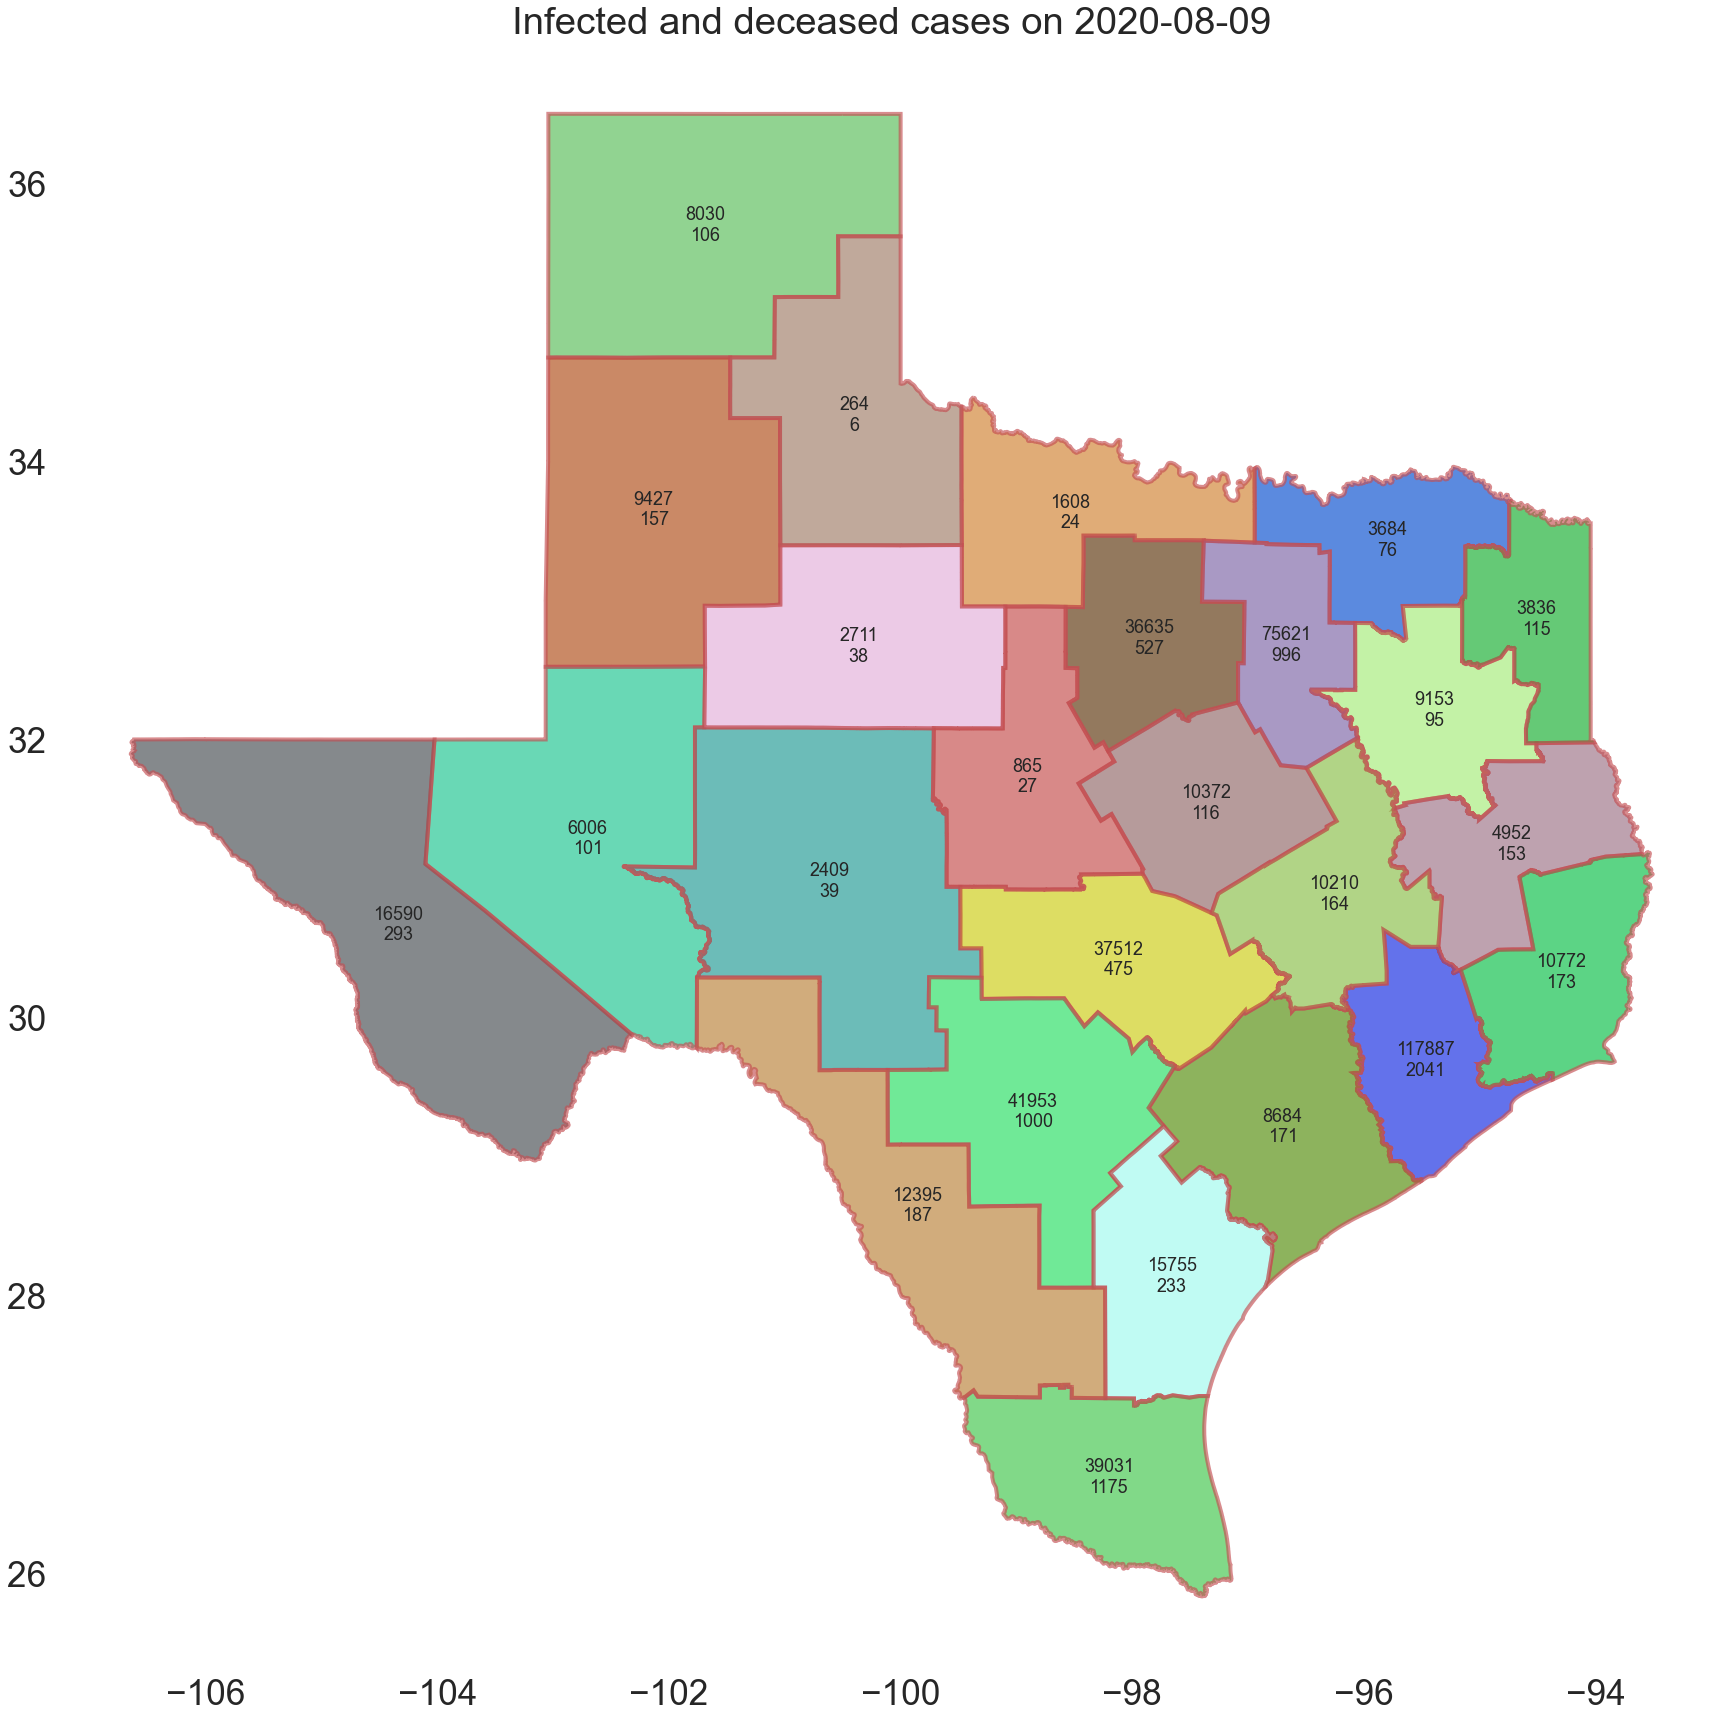

In [41]:
fig = plt.figure(figsize=(30, 30))
# plt.axis([x_min, x_max, y_min, y_max])
plt.autoscale(enable=True, axis='both')
plt.gca().set_facecolor("white")

data_view_t = diff_day(DATA_DAY_BEGIN, [9,8,2020])
        
def plot_dist():
    ax = fig.gca() 
    for i in range(len(new_dist_geom)):
        poly = new_dist_geom[i]
        ax.add_patch(PolygonPatch(poly, fill=True, fc=np.random.rand(3,), ec='r',  
                                  alpha=0.65, zorder=2, linewidth=4))
        plt.text(poly.centroid.xy[0][0], poly.centroid.xy[1][0], 
                 str(dist_infected_total_cases[data_view_t][i])  
                 + '\n' + str(dist_deceased_cases[data_view_t][i]),
                 ha='center', va='center', fontsize='18')
    


# plot_tri()
plot_dist()
plt.title('Infected and deceased cases on {}'.format(covid_data_tdate[data_view_t].date()))
# plt.savefig('plot_district_simple_cases_{}_{}.pdf'.format(covid_data_tdate[data_view_t].date(), mesh_fname))
plt.show()

# Plot county data

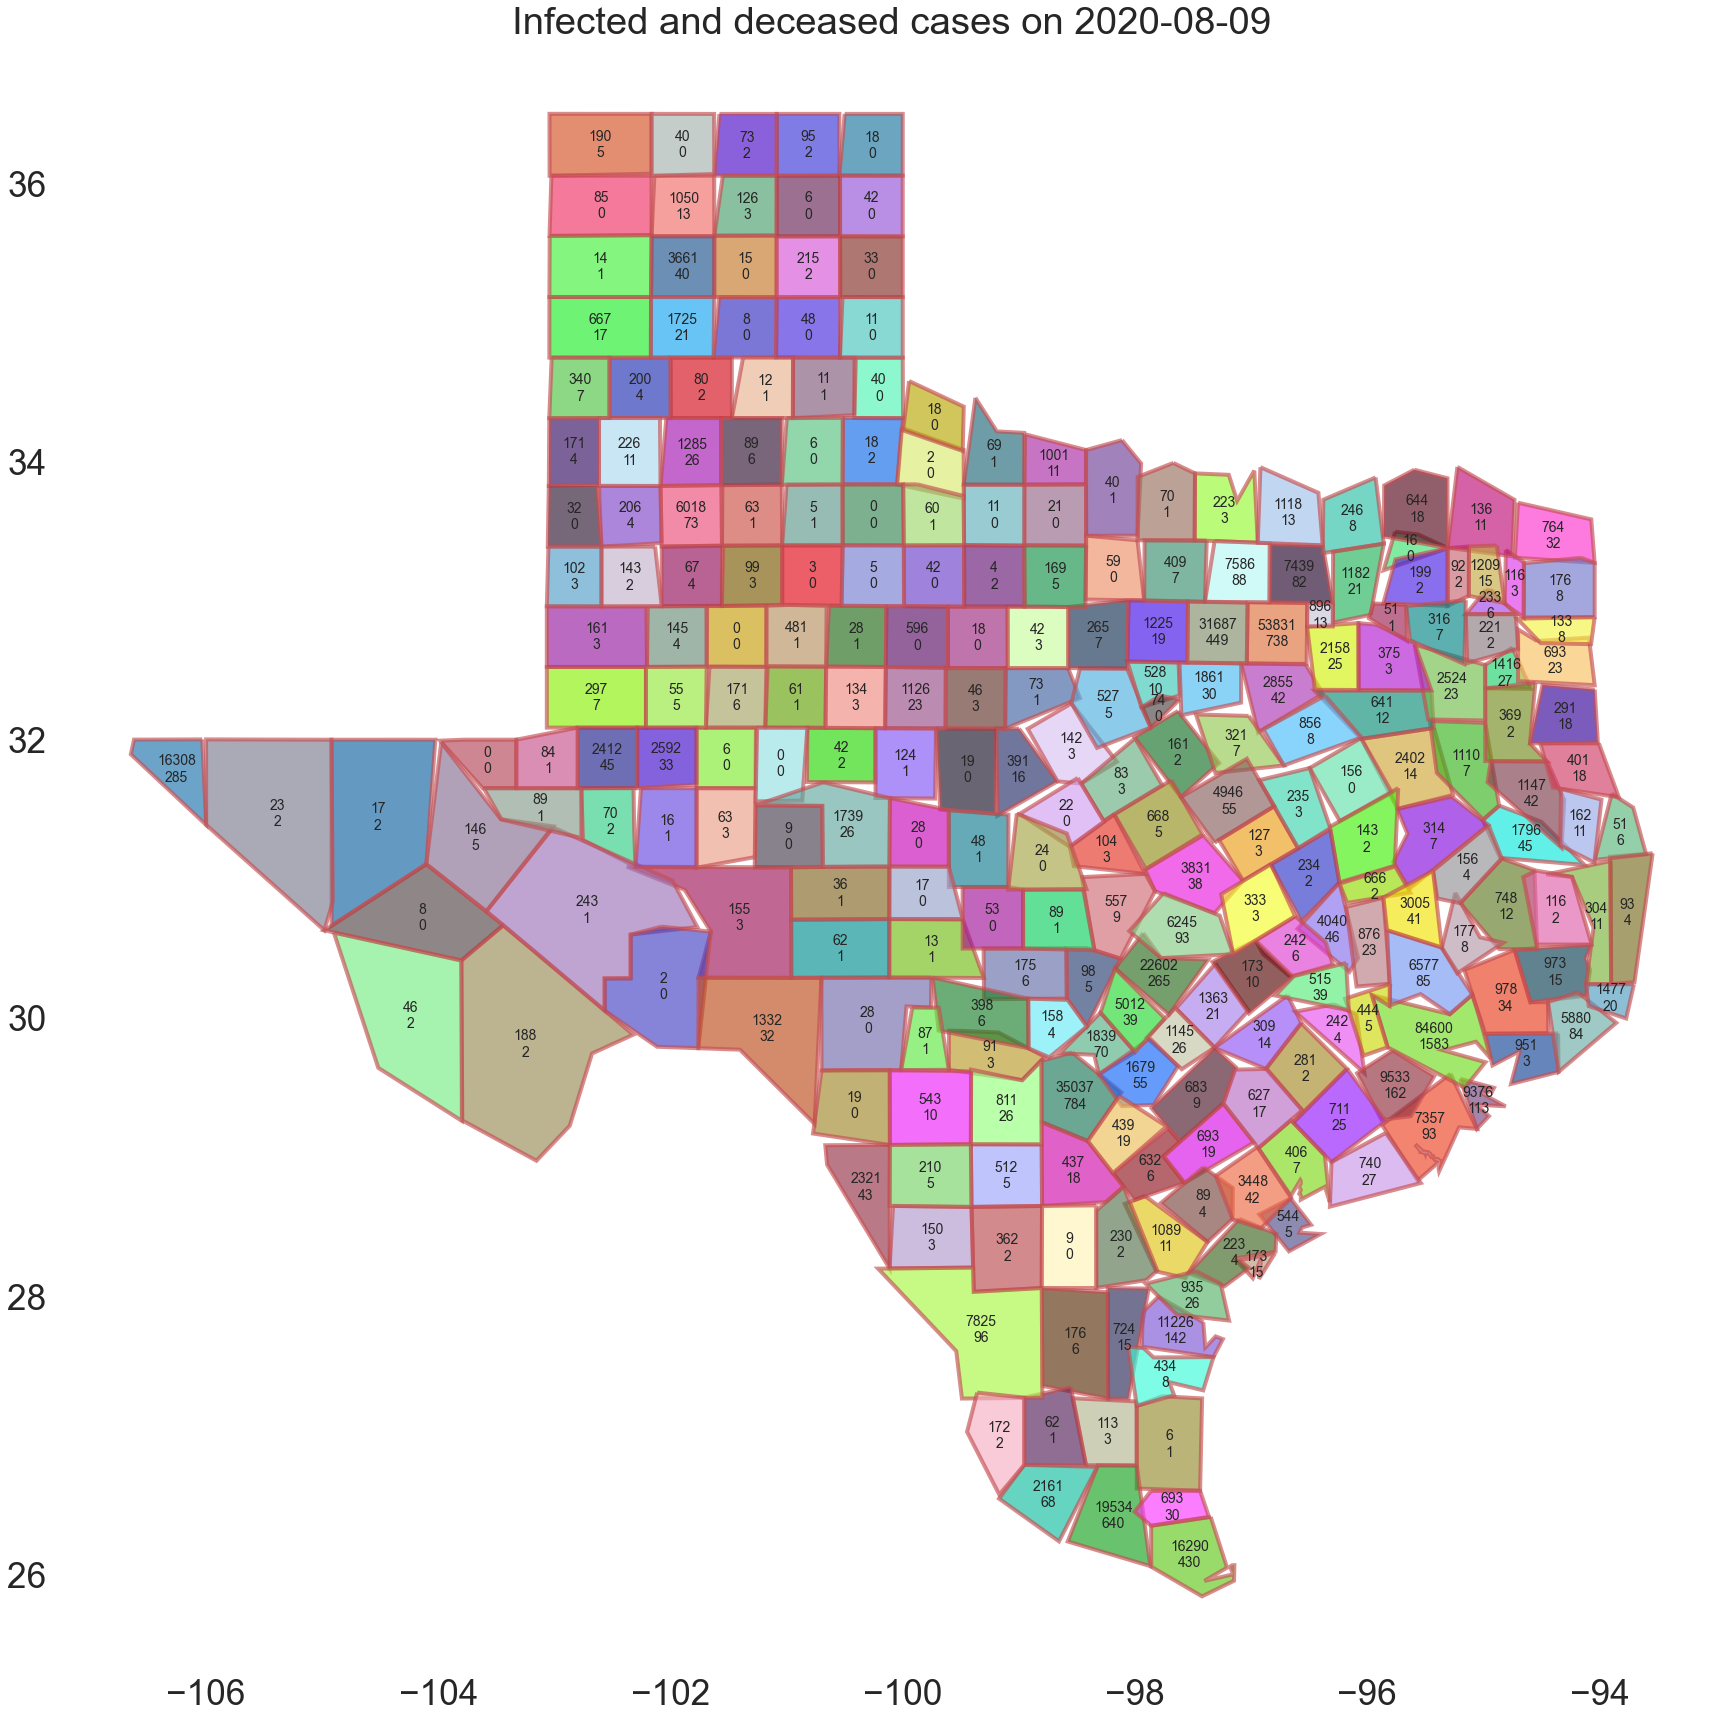

In [45]:
fig = plt.figure(figsize=(30, 30))
# plt.axis([x_min, x_max, y_min, y_max])
plt.autoscale(enable=True, axis='both')
plt.gca().set_facecolor("white")

data_view_t = diff_day(DATA_DAY_BEGIN, [9,8,2020])
        
def plot_county():
    ax = fig.gca() 
    for i in range(len(county_polys)):
        poly = county_polys[i][0]
        ax.add_patch(PolygonPatch(poly, fill=True, fc=np.random.rand(3,), 
                                  ec='r', alpha=0.65, zorder=2, linewidth=4))
        plt.text(poly.centroid.xy[0][0], poly.centroid.xy[1][0], 
                 str(county_infected_total_cases[data_view_t][i]) 
                 + '\n' + str(county_deceased_cases[data_view_t][i]), 
                 ha='center', va='center', fontsize='14')
    


# plot_tri()
plot_county()
plt.title('Infected and deceased cases on {}'.format(covid_data_tdate[data_view_t].date()))
# plt.savefig('plot_district_simple_cases_{}_{}.pdf'.format(covid_data_tdate[data_view_t].date(), mesh_fname))
plt.show()

Text(0.5, 1.0, 'Total population and deceased cases on 2020-08-09')

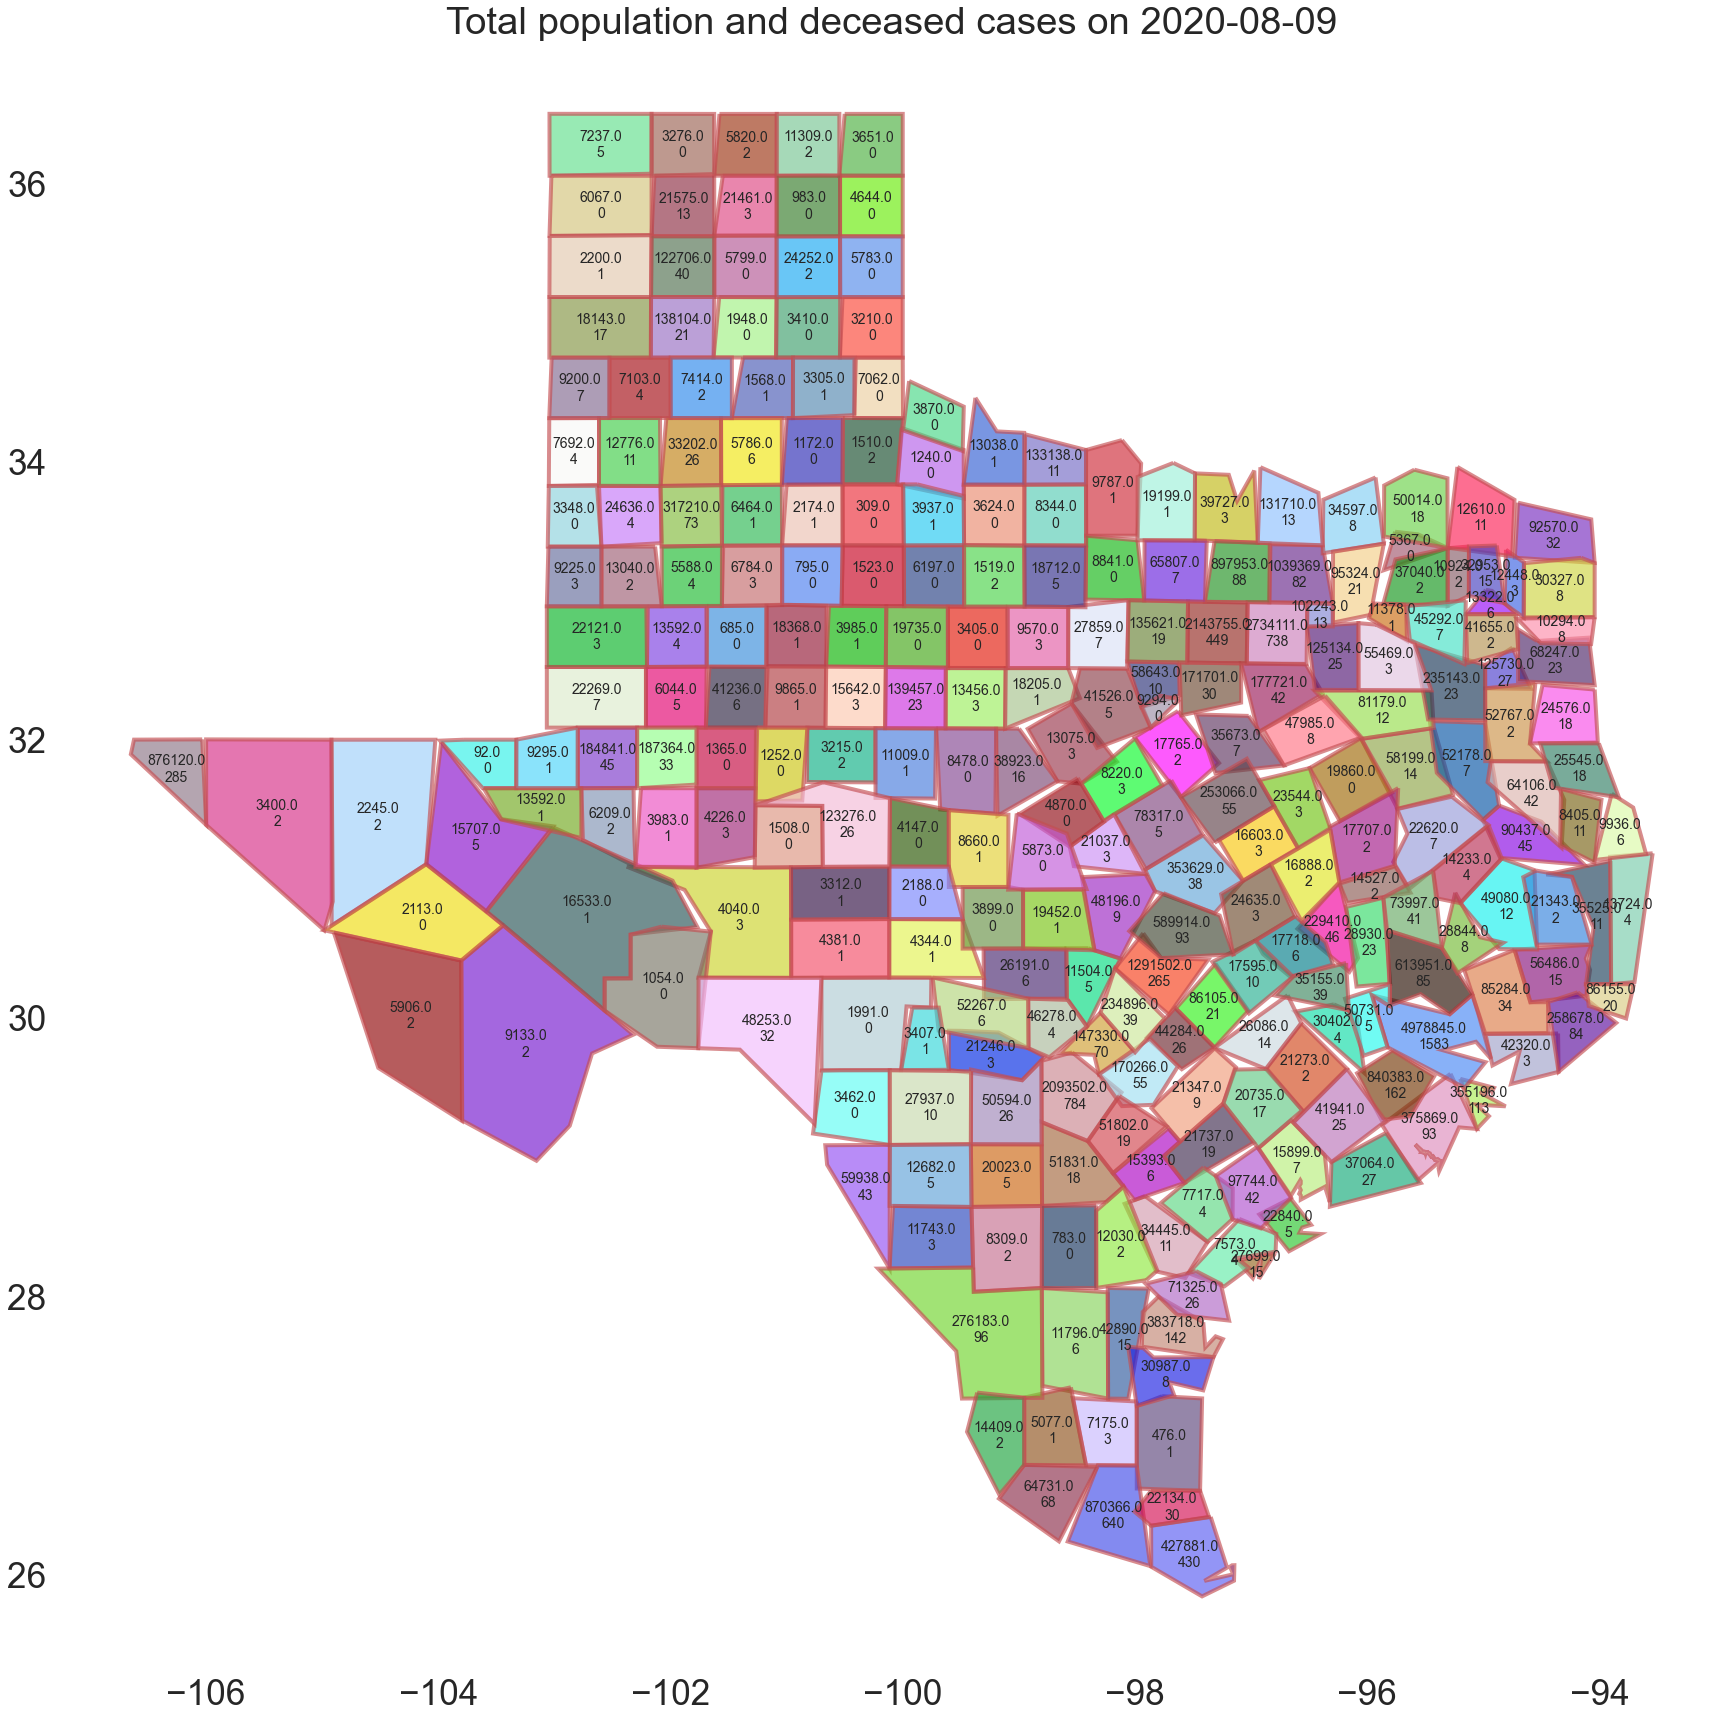

In [48]:
fig = plt.figure(figsize=(30, 30))
# plt.axis([x_min, x_max, y_min, y_max])
plt.autoscale(enable=True, axis='both')
plt.gca().set_facecolor("white")

data_view_t = diff_day(DATA_DAY_BEGIN, [9,8,2020])

county_population = np.loadtxt('county_population.txt')
        
def plot_county():
    ax = fig.gca() 
    for i in range(len(county_polys)):
        poly = county_polys[i][0]
        ax.add_patch(PolygonPatch(poly, fill=True, fc=np.random.rand(3,), 
                                  ec='r', alpha=0.65, zorder=2, linewidth=4))
        plt.text(poly.centroid.xy[0][0], poly.centroid.xy[1][0], 
                 str(county_population[i]) 
                 + '\n' + str(county_deceased_cases[data_view_t][i]), 
                 ha='center', va='center', fontsize='14')
    


# plot_tri()
plot_county()
plt.title('Total population and deceased cases on {}'.format(covid_data_tdate[data_view_t].date()))
# plt.savefig('plot_district_simple_cases_{}_{}.pdf'.format(covid_data_tdate[data_view_t].date(), mesh_fname))

# Get transition day data for each county

In [49]:
county_infected_total_cases = np.array(county_infected_total_cases)
county_infected_active_cases = np.array(county_infected_active_cases)
county_deceased_cases = np.array(county_deceased_cases)
county_recovered_cases = np.array(county_recovered_cases)

county_infected_total_transition_day = [-1 for i in range(N_counties)]
county_infected_active_transition_day = [-1 for i in range(N_counties)]
county_deceased_transition_day = [-1 for i in range(N_counties)]
county_recovered_transition_day = [-1 for i in range(N_counties)]
for i in range(N_counties):
    
    inf_tot_data = county_infected_total_cases[:, i]
    inf_act_data = county_infected_active_cases[:, i]
    dec_data = county_deceased_cases[:, i]
    rec_data = county_recovered_cases[:, i]
    
    N = len(inf_tot_data)
    
    # sort this in increasing
    cit = -1
    cat = -1
    cd = -1
    cr = -1
    
    for j in range(N-1):
        if inf_tot_data[j] == 0 and inf_tot_data[j+1] > 0:
            cit = j
        if inf_act_data[j] == 0 and inf_act_data[j+1] > 0:
            cat = j
        if dec_data[j] == 0 and dec_data[j+1] > 0:
            cd = j
        if rec_data[j] == 0 and rec_data[j+1] > 0:
            cr = j
            
    county_infected_total_transition_day[i] = cit
    county_infected_active_transition_day[i] = cat
    county_deceased_transition_day[i] = cd
    county_recovered_transition_day[i] = cr
    print('{0:<6} {1:<6} {2:<6} {3:<6} {4}'.format(i, cit, inf_tot_data[cit], inf_tot_data[cit+1], len(inf_tot_data)))
    print('{0:<6} {1:<6} {2:<6} {3:<6} {4}'.format(i, cd, dec_data[cd], dec_data[cd+1], len(dec_data)))

0      24     0      1      156
0      36     0      1      156
1      27     0      1      156
1      79     0      1      156
2      18     0      1      156
2      36     0      1      156
3      28     0      1      156
3      119    0      1      156
4      68     0      1      156
4      -1     0      0      156
5      37     0      1      156
5      -1     0      0      156
6      17     0      2      156
6      39     0      1      156
7      17     0      1      156
7      48     0      1      156
8      58     0      1      156
8      104    0      1      156
9      32     0      1      156
9      110    0      1      156
10     17     0      1      156
10     22     0      1      156
11     89     0      3      156
11     -1     0      0      156
12     31     0      1      156
12     118    0      1      156
13     7      0      1      156
13     18     0      1      156
14     7      0      3      156
14     13     0      1      156
15     16     0      1      156
15     7

In [50]:
np.savetxt(data_path + 'processed/infected_total_transition_day_county.txt', county_infected_total_transition_day)
np.savetxt(data_path + 'processed/infected_active_transition_day_county.txt', county_infected_active_transition_day)
np.savetxt(data_path + 'processed/deceased_transition_day_county.txt', county_deceased_transition_day)
np.savetxt(data_path + 'processed/recovered_transition_day_county.txt', county_recovered_transition_day)

# Test two data sets

In [54]:
data_path_1 = 'Data_25June2020/'
data_path_2 = 'Data_11August2020/'
proc_inf_tot_1 = np.loadtxt(data_path_1 + 'processed/infected_total_state.txt')
proc_inf_act_1 = np.loadtxt(data_path_1 + 'processed/infected_active_state.txt')
proc_dec_1 = np.loadtxt(data_path_1 + 'processed/deceased_state.txt')
proc_rec_1 = np.loadtxt(data_path_1 + 'processed/recovered_state.txt')

In [55]:
proc_inf_tot_2 = np.loadtxt(data_path_2 + 'processed/infected_total_state.txt')
proc_inf_act_2 = np.loadtxt(data_path_2 + 'processed/infected_active_state.txt')
proc_dec_2 = np.loadtxt(data_path_2 + 'processed/deceased_state.txt')
proc_rec_2 = np.loadtxt(data_path_2 + 'processed/recovered_state.txt')

In [57]:
N_small = len(proc_inf_tot_1)

sum_er_inf_tot = 0
sum_er_inf_act = 0
sum_er_dec = 0
for i in range(N_small):
    
    error_found = 0
    
    if proc_inf_tot_1[i] != proc_inf_tot_2[i]:
        error_found = 1
        sum_er_inf_tot += 1
    if proc_inf_act_1[i] != proc_inf_act_2[i]:
        error_found = 1
        sum_er_inf_act += 1
    if proc_dec_1[i] != proc_dec_2[i]:
        error_found = 1
        sum_er_dec += 1
        
    if error_found == 1:
        print('{0:<4} t: {1}  inf tot(1) {2:<8} inf tot(2) {3:<8} inf act(1) {4:<8} inf act(2) {5:<8} dec(1) {6:<8} dec(2) {7:<8}'.format(i,
            covid_data_tdate[i].date(), 
            proc_inf_tot_1[i], proc_inf_tot_2[i], proc_inf_act_1[i], proc_inf_act_2[i], proc_dec_1[i], proc_dec_2[i]))
    
print('sum_er_inf_tot: {0:<5} sum_er_inf_act: {1:<5} sum_er_dec: {2}'.format(sum_er_inf_tot, sum_er_inf_act, sum_er_dec))


2    t: 2020-03-09  inf tot(1) 5.0      inf tot(2) 12.0     inf act(1) 5.0      inf act(2) 12.0     dec(1) 0.0      dec(2) 0.0     
3    t: 2020-03-10  inf tot(1) 12.0     inf tot(2) 15.0     inf act(1) 12.0     inf act(2) 15.0     dec(1) 0.0      dec(2) 0.0     
4    t: 2020-03-11  inf tot(1) 15.0     inf tot(2) 18.0     inf act(1) 15.0     inf act(2) 18.0     dec(1) 0.0      dec(2) 0.0     
5    t: 2020-03-12  inf tot(1) 18.0     inf tot(2) 22.0     inf act(1) 18.0     inf act(2) 22.0     dec(1) 0.0      dec(2) 0.0     
8    t: 2020-03-15  inf tot(1) 22.0     inf tot(2) 56.0     inf act(1) 22.0     inf act(2) 55.0     dec(1) 0.0      dec(2) 1.0     
9    t: 2020-03-16  inf tot(1) 56.0     inf tot(2) 56.0     inf act(1) 56.0     inf act(2) 54.0     dec(1) 0.0      dec(2) 2.0     
10   t: 2020-03-17  inf tot(1) 56.0     inf tot(2) 63.0     inf act(1) 56.0     inf act(2) 59.0     dec(1) 0.0      dec(2) 4.0     
11   t: 2020-03-18  inf tot(1) 63.0     inf tot(2) 82.0     inf act(1) 62.0 

In [ ]:
covid_data_tdate[79].date()

In [ ]:
proc_inf_tot_county_1 = np.loadtxt(data_path_1 + 'processed/infected_total_county.txt')
proc_inf_act_county_1 = np.loadtxt(data_path_1 + 'processed/infected_active_county.txt')
proc_dec_county_1 = np.loadtxt(data_path_1 + 'processed/deceased_county.txt')
proc_rec_county_1 = np.loadtxt(data_path_1 + 'processed/recovered_county.txt')

In [ ]:
proc_inf_tot_county_2 = np.loadtxt(data_path_2 + 'processed/infected_total_county.txt')
proc_inf_act_county_2 = np.loadtxt(data_path_2 + 'processed/infected_active_county.txt')
proc_dec_county_2 = np.loadtxt(data_path_2 + 'processed/deceased_county.txt')
proc_rec_county_2 = np.loadtxt(data_path_2 + 'processed/recovered_county.txt')

In [ ]:
# error in total infected
tot_inf_er_county = 0
for i in range(N_small):
    
    cts = []
    for j in range(len(proc_inf_tot_county_1[i])):
        if proc_inf_tot_county_1[i][j] != proc_inf_tot_county_2[i][j]:
            tot_inf_er_county += 1
            print('i: {0:<4} t: {1:<8} cty: {2:<6} data 1: {3:<5} data 2: {4}'.format(i, 
                    covid_data_tdate[i].date(), county_nms[j], proc_inf_tot_county_1[i][j], proc_inf_tot_county_2[i][j]))

            
print('tot er: {}'.format(tot_inf_er_county))

In [ ]:
# error in active infected
act_inf_er_county = 0
for i in range(N_small):
    
    cts = []
    for j in range(len(proc_inf_act_county_1[i])):
        if proc_inf_act_county_1[i][j] != proc_inf_act_county_2[i][j]:
            act_inf_er_county += 1
            print('i: {0:<4} t: {1} cty: {2:<6} data 1: {3:<5} data 2: {4}'.format(i, 
                    covid_data_tdate[i].date(), county_nms[j], proc_inf_act_county_1[i][j], proc_inf_act_county_2[i][j]))

            
print('tot er: {}'.format(act_inf_er_county))


In [ ]:
# error in total infected
dec_er_county = 0
for i in range(N_small):
    
    cts = []
    for j in range(len(proc_dec_county_1[i])):
        if proc_dec_county_1[i][j] != proc_dec_county_2[i][j]:
            dec_er_county += 1
            print('i: {0:<4} t: {1:<8} cty: {2:<6} data 1: {3:<5} data 2: {4}'.format(i, 
                    covid_data_tdate[i].date(), county_nms[j], proc_dec_county_1[i][j], proc_dec_county_2[i][j]))

            
print('tot er: {}'.format(dec_er_county))

In [ ]:
# a = [0, 0, 0, 0, 10, 12, 15]
a = [0, 0, 0, 0, 0, 0, 0]
b = -1
for i in range(6):
    if a[i] == 0 and a[i+1] > 0:
        b = i
        
b, a[b], a[b+1]

In [ ]:
a = [np.random.randint(100) for i in range(100)]
print(a)

a = np.sort(a)
print(a)